# Data conversion between numpy  ctypes 
# numpy数据转换到ctypes类型时的问题
*****************************************
近日，我想利用python中的ctypes调用c++函数对图片进行处理，在进行单张图片验证时没有问题，放到整训练流程中，出现了c++读取了错误图片数据的错误。在经过逐步核查后发现了如下问题。  
对于将numpy.float32 array强制转换为np.uint8,再转为ctypes.Pointer(ctypes.c_ubyte)时，发现python 在偷偷懈怠。  
具体如下：

[[[ 92.  92.  92.]
  [ 98.  98.  98.]
  [100. 100. 100.]
  ...
  [ 61.  61.  61.]
  [ 59.  59.  59.]
  [ 54.  54.  54.]]

 [[ 83.  83.  83.]
  [ 85.  85.  85.]
  [ 91.  91.  91.]
  ...
  [ 59.  59.  59.]
  [ 44.  44.  44.]
  [ 56.  56.  56.]]

 [[ 87.  87.  87.]
  [ 81.  81.  81.]
  [ 86.  86.  86.]
  ...
  [ 69.  69.  69.]
  [ 46.  46.  46.]
  [ 35.  35.  35.]]

 ...

 [[ 30.  30.  30.]
  [ 34.  34.  34.]
  [ 30.  30.  30.]
  ...
  [ 60.  60.  60.]
  [ 63.  63.  63.]
  [ 90.  90.  90.]]

 [[ 35.  35.  35.]
  [ 34.  34.  34.]
  [ 33.  33.  33.]
  ...
  [ 99.  99.  99.]
  [ 86.  86.  86.]
  [ 80.  80.  80.]]

 [[ 34.  34.  34.]
  [ 36.  36.  36.]
  [ 45.  45.  45.]
  ...
  [ 95.  95.  95.]
  [ 93.  93.  93.]
  [ 98.  98.  98.]]]


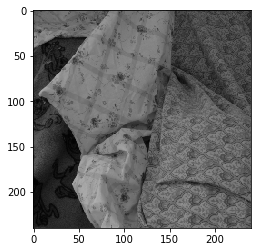

In [7]:
import ctypes
import cv2
import numpy as np
import time 
import matplotlib.pyplot as plt
%matplotlib inline

color = cv2.imread("./pic/bw.bmp").astype(np.float32)
print(color)
plt.imshow(color[:,:,(2,1,0)]/255.0)


这里我将这个输入图像转为ctypes.c_unit8类型，打印出第一个像素的值，命令如下：

In [8]:
color_in = np.asarray(color,dtype=np.uint8).ctypes.data_as(ctypes.POINTER(ctypes.c_uint8)) 
print(color_in.contents)

c_ubyte(144)


这里发现ctypes指针指向的第一个像素值是144，而不是之前的92。感觉有点奇怪。于是把上面那个命令分成两行执行：

In [9]:
color_wb = np.asarray(color,dtype=np.uint8)
color_in = color_wb.ctypes.data_as(ctypes.POINTER(ctypes.c_ubyte))
print(color_in.contents)

c_ubyte(92)


这里发现分成两句后就可以正确执行了，感觉很是悬妙。莫非连起来写的时候，numpy的类型强制转换会被忽略？然后我又取了color中的一些元素进行实验。

In [11]:
a = np.asarray(color[0:2,0:2,:],dtype=np.uint8).ctypes.data_as(ctypes.POINTER(ctypes.c_uint8))
print(a.contents)
b = np.asarray(color[0,:,:],dtype=np.uint8).ctypes.data_as(ctypes.POINTER(ctypes.c_uint8))
print(b.contents)
b = np.asarray(color[:,0,:],dtype=np.uint8).ctypes.data_as(ctypes.POINTER(ctypes.c_uint8))
print(b.contents)
c = np.asarray(color[:,:,0],dtype=np.uint8).ctypes.data_as(ctypes.POINTER(ctypes.c_uint8))
print(c.contents)
d = np.asarray(color[:,:,:],dtype=np.uint8).ctypes.data_as(ctypes.POINTER(ctypes.c_uint8))
print(d.contents)

c_ubyte(92)
c_ubyte(92)
c_ubyte(92)
c_ubyte(192)
c_ubyte(144)


这里可发现当取array中部分元素时，类型的强制转换还是可以的。但是当array的前两维为满取时，这时转换后的ctype指针内容发生错误，我实在是不明白这里是为什么。希望能找到答案。其他类型还没有进行检验，只是今天发现了这个问题。